# **Sentiment Analysis SVM**

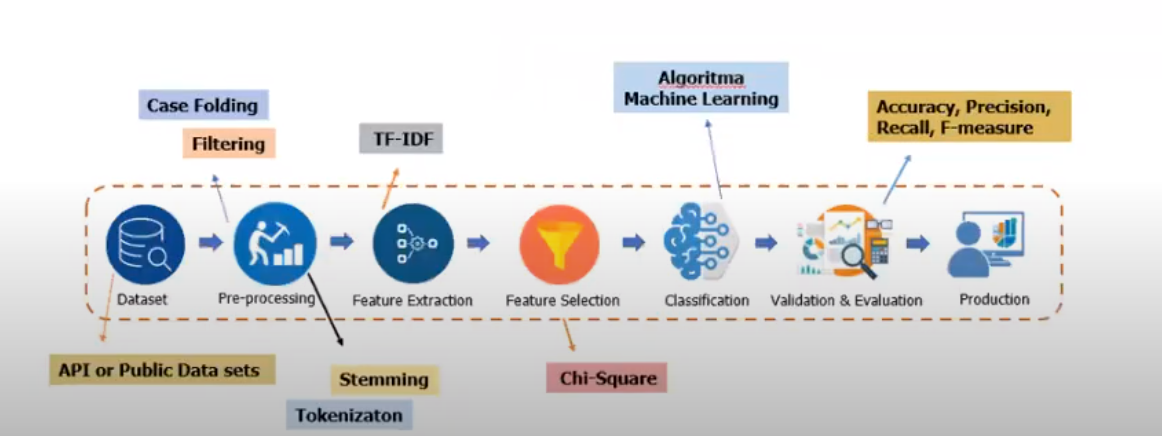

## **1. Mount data ke gdrive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **2. Install Library yang digunakan**

In [2]:
!pip install nltk

In [3]:
import pandas as pd # Pandas juga dapat membaca file dari berbagai format seperti .txt, .csv, .tsv, dan lainnya
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re # ekspresi reguler adalah urutan karakter khusus yang membantu Anda mencocokkan atau menemukan string atau kumpulan string lain
import string
import nltk # libray python untuk bekerja dengan permodelan teks
nltk.download('punkt')
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
!pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


## **3. Menampilkan dataset**

In [5]:
data = pd.read_csv("gdrive/MyDrive/Dataset/dataset_komentar_instagram_cyberbullying.csv")
data.head(400)

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...,...
395,396,positive,Bangga sama suami yg selalu ingat istri disela...
396,397,positive,Apaoun pekerjaannya yg penting halal u tuk men...
397,398,positive,Gojek itu mayoritas pegangguran yang lama gak ...
398,399,positive,<USERNAME> aslinya cantik dan ayu loh mbak kr...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      400 non-null    int64 
 1   Sentiment               400 non-null    object
 2   Instagram Comment Text  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


### **4. Pelabelan**

In [7]:
from sklearn.preprocessing import LabelEncoder

#membuat label encoder
le = LabelEncoder()

#fitting label encoder pada kolom Sentiment
le.fit(data['Sentiment'])

#menampilkan label encoder
print('Kelas sentimen:', le.classes_)

#transformasi kelas sentimen menjadi angka
data['Sentiment'] = le.transform(data['Sentiment'])

Kelas sentimen: ['negative' 'positive']


In [8]:
print('Total Jumlah Komentar:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] Negative\t:', data[data.Sentiment == 0].shape[0], 'data')
print('-- [1] Positive\t:', data[data.Sentiment == 1].shape[0], 'data')

Total Jumlah Komentar: 400 data

terdiri dari (label):
-- [0] Negative	: 200 data
-- [1] Positive	: 200 data


In [9]:
data.head(400)

,Id,Sentiment,Instagram Comment Text
0,1,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,0,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,0,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...,...
395,396,1,Bangga sama suami yg selalu ingat istri disela...
396,397,1,Apaoun pekerjaannya yg penting halal u tuk men...
397,398,1,Gojek itu mayoritas pegangguran yang lama gak ...
398,399,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...


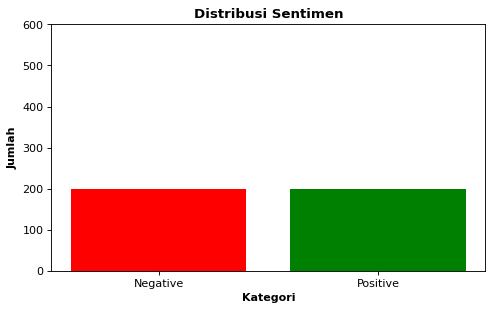

In [10]:
height = data['Sentiment'].value_counts()
Sentiments = ('Negative', 'Positive')
y_pos = np.arange(len(Sentiments))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Sentimen', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['red','green'])
plt.xticks(y_pos, Sentiments)
plt.show()

### **5. PREPROCESSING**

In [11]:
#CASEFOLDING

import re

#buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                     #mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\s+', '', text)     #menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)               #menghapus angka
  text = re.sub(r'[^\w\s]', '', text)                   #menghapus karakter tanda baca
  text = text.strip()
  return text

In [12]:
raw_sample = data['Instagram Comment Text'].iloc[0]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:   <USERNAME> TOLOL!! Gak ada hubungan nya keguguran dgn pake hijab syar'i yg lo bilang bayi nya kepanasan didalem gak ada hubungan nya woyyyy!! Otak sama jempol lo gak singkron sih ya jadinya asal nulis komentar!
Case folding	:  username tolol gak ada hubungan nya keguguran dgn pake hijab syari yg lo bilang bayi nya kepanasan didalem gak ada hubungan nya woyyyy otak sama jempol lo gak singkron sih ya jadinya asal nulis komentar


In [13]:
#normalisasi
#download corpus kumpulan slangwords dari github

!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2023-11-19 01:08:59--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>]  79.07K  --.-KB/s    in 0.02s   

2023-11-19 01:09:00 (3.49 MB/s) - ‘key_norm.csv’ saved [80969/80969]



In [14]:
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [15]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

In [16]:
#filtering (stopword removal)

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [17]:
len(stopwords_ind)

758

In [18]:
#lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [19]:
#buat fungsi untuk langkah stopword removal

more_stopword = ['geblek', 'tolol', 'bangsat', 'username']        #tambah kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
    if word not in stopwords_ind:
      clean_words.append(word)
  return " ".join(clean_words)

In [20]:
raw_sample = data['Instagram Comment Text'].iloc[0]
case_folding = casefolding(raw_sample)
stopword_removal =  remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)



Raw data		:   <USERNAME> TOLOL!! Gak ada hubungan nya keguguran dgn pake hijab syar'i yg lo bilang bayi nya kepanasan didalem gak ada hubungan nya woyyyy!! Otak sama jempol lo gak singkron sih ya jadinya asal nulis komentar!
Case folding		:  username tolol gak ada hubungan nya keguguran dgn pake hijab syari yg lo bilang bayi nya kepanasan didalem gak ada hubungan nya woyyyy otak sama jempol lo gak singkron sih ya jadinya asal nulis komentar
Stopword removal	:  gak hubungan nya keguguran dgn pake hijab syari yg lo bilang bayi nya kepanasan didalem gak hubungan nya woyyyy otak jempol lo gak singkron sih ya nulis komentar


In [21]:
#stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

#buat fungsi untuk langkah stemming bahasa indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [22]:
raw_sample = data['Instagram Comment Text'].iloc[0]
case_folding = casefolding(raw_sample)
stopword_removal =  remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:   <USERNAME> TOLOL!! Gak ada hubungan nya keguguran dgn pake hijab syar'i yg lo bilang bayi nya kepanasan didalem gak ada hubungan nya woyyyy!! Otak sama jempol lo gak singkron sih ya jadinya asal nulis komentar!
Case folding		:  username tolol gak ada hubungan nya keguguran dgn pake hijab syari yg lo bilang bayi nya kepanasan didalem gak ada hubungan nya woyyyy otak sama jempol lo gak singkron sih ya jadinya asal nulis komentar
Stopword removal	:  gak hubungan nya keguguran dgn pake hijab syari yg lo bilang bayi nya kepanasan didalem gak hubungan nya woyyyy otak jempol lo gak singkron sih ya nulis komentar
Stemming		:  gak hubung nya gugur dgn pake hijab syar yg lo bilang bayi nya panas dalem gak hubung nya woyyyy otak jempol lo gak singkron sih ya nulis komentar


In [23]:
#preprocessing lagi

#buat fungsi unruk menggabungkan seluruh langkah preprocessing

def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [24]:
%%time
data['clean_teks'] = data['Instagram Comment Text'].apply(text_preprocessing_process)

#perhatikan waktu komputasi ketika proses text processing

CPU times: user 4min 3s, sys: 525 ms, total: 4min 3s
Wall time: 4min 9s


In [25]:
data

,Id,Sentiment,Instagram Comment Text,clean_teks
0,1,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,hubung nya gugur pakai hijab syar bilang bayi ...
1,2,0,Geblek lo tata...cowo bgt dibela2in balikan......,bodoh tatacowo banget bain balikanhadewwntar t...
2,3,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin mewek skr lengket duhhh labil banget s...
3,4,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",inti kesel att nya anak kasihan kembang psikis...
4,5,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan lgsakit jiwaknp peran utama...
...,...,...,...,...
395,396,1,Bangga sama suami yg selalu ingat istri disela...,bangga suami istri sela apa profesi kau juara ...
396,397,1,Apaoun pekerjaannya yg penting halal u tuk men...,apaoun kerja halal tuk nafkah keluarga semangat
397,398,1,Gojek itu mayoritas pegangguran yang lama gak ...,gojek mayoritas pegangguran kerja putus asaa t...
398,399,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...,asli cantik ayu loh mbak temu langsung sembak ...


In [26]:
#simpan data agar tidak menjalankan proses ulang
data.to_csv('clean_data.csv')

### **6. FEATURE ENGINEERING**

In [27]:
#pisahkan kolom fitur dan target

x = data['clean_teks']
y = data['Sentiment']

In [28]:
x

0      hubung nya gugur pakai hijab syar bilang bayi ...
1      bodoh tatacowo banget bain balikanhadewwntar t...
2      kemarin mewek skr lengket duhhh labil banget s...
3      inti kesel att nya anak kasihan kembang psikis...
4      hadewwwww permpuan lgsakit jiwaknp peran utama...
                             ...                        
395    bangga suami istri sela apa profesi kau juara ...
396      apaoun kerja halal tuk nafkah keluarga semangat
397    gojek mayoritas pegangguran kerja putus asaa t...
398    asli cantik ayu loh mbak temu langsung sembak ...
399    suami umur mbak tua alhamdulillah suami kekana...
Name: clean_teks, Length: 400, dtype: object

In [29]:
y

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    1
399    1
Name: Sentiment, Length: 400, dtype: int64

**7. FEATURE EXTRACTION (BAG OF WORDS)**

Proses mengubah teks menjadi vektor

In [30]:
#tfidf dan n-gram

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(x)

TfidfVectorizer()

In [31]:
#melihat jumlah fitur
print(len(tf_idf.get_feature_names_out()))

2313


In [32]:
#melihat fitur-fitur apa saja ang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aamiin' 'aammiinnn' 'abal' ... 'zholimi' 'zina' 'zzzzz']


In [33]:
#melihat matriks jumlah token
#data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

x_tf_idf = tf_idf.transform(x).toarray()
x_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
#melihat matriks jumlah token menggunakan tf idf, lihat perbedaan dengan bow
#data siap dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(x_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aamiin,aammiinnn,abal,abang,abbey,abege,abiiis,abiss,abu,ac,...,yh,yoo,youtube,yra,yuk,yutub,zaman,zholimi,zina,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.237377,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(x_tf_idf, output)

**8. FEATURE SELECTION**

In [36]:
#mengubah nilai data tabular tf idf menjadi array aggar dapat dijalankan pada proses seleksi fitur

x = np.array(data_tf_idf)
y = np.array(y)

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#ten features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k=1000)
x_kbest_features = chi2_features.fit_transform(x,y)

#reduced features
print('Original feature number: ', x.shape[1])
print('Reduced feature number: ', x_kbest_features.shape[1])

Original feature number:  2313
Reduced feature number:  1000


In [39]:
#chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya

data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.712649
1,0.266905
2,1.016960
3,0.001270
4,0.488178
...,...
2308,0.215649
2309,0.183404
2310,0.226724
2311,0.331307


In [40]:
#menampilkan fitur beserta nilainya

feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.712649,aamiin
1,0.266905,aammiinnn
2,1.016960,abal
3,0.001270,abang
4,0.488178,abbey
...,...,...
2308,0.215649,yutub
2309,0.183404,zaman
2310,0.226724,zholimi
2311,0.331307,zina


In [41]:
#mengurutkan fitur terbaik

data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
442,7.469651,cantik
1386,5.487262,moga
374,5.391290,bodoh
1014,4.316744,kampung
1085,4.272573,keren
...,...,...
2289,0.000080,yaelah
2050,0.000038,sumpah
1849,0.000005,sakit
1777,0.000004,publik


In [42]:
#menampilkan mask pada feature yang diseleksi
#False berarti fitur tidak terpilih dan True berarti fitur terpilih

mask = chi2_features.get_support()
mask

array([ True, False,  True, ..., False,  True,  True])

In [52]:
#menampilkan fitur-fitur terpilih  berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi padda Chi-square

new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

In [53]:
selected_feature

['aamiin',
 'abal',
 'abbey',
 'abiiis',
 'acha',
 'adat',
 'admin',
 'agus',
 'ah',
 'aja',
 'ajaaa',
 'akhlak',
 'akun',
 'akuuu',
 'alah',
 'alami',
 'alay',
 'alesha',
 'alhamdulillah',
 'alim',
 'allah',
 'allahaamiin',
 'am',
 'amanda',
 'amiiii',
 'amiiin',
 'amiin',
 'amin',
 'amit',
 'amora',
 'ampuuunmalu',
 'an',
 'anakanaknya',
 'anang',
 'anda',
 'andah',
 'anehkyknya',
 'angguunn',
 'ani',
 'anjing',
 'anjir',
 'anjirrrr',
 'antem',
 'anti',
 'anyiennnnggg',
 'apa',
 'apain',
 'apaoun',
 'api',
 'apik',
 'aplg',
 'ariel',
 'artika',
 'artis',
 'ashanti',
 'asik',
 'aslikereennn',
 'asyik',
 'ato',
 'att',
 'audisi',
 'aura',
 'aurel',
 'aw',
 'awat',
 'awet',
 'ayah',
 'ayu',
 'ayuneemana',
 'ayuuterlihat',
 'az',
 'azriel',
 'babang',
 'babi',
 'babiii',
 'baca',
 'bacot',
 'badaaiik',
 'baguass',
 'bagus',
 'bagusss',
 'bagussss',
 'bahagia',
 'baik',
 'bak',
 'bakat',
 'bala',
 'balajaer',
 'balas',
 'balikanhadewwntar',
 'banci',
 'bang',
 'bangeeet',
 'bangeg',
 'ban

In [54]:
#cara melihat vocab yang dihasilkan oleh tf idf
#tf_idf.vocabulary_

kbest_feature = {} #buat dictionary kosong

for(k,v) in tf_idf.vocabulary_.items():         #iterasi untuk mengulangi vocab yang dihasilkan tf_idf
  if k in selected_feature:                     #cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                        #jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [55]:
kbest_feature

{'nya': 1557,
 'pakai': 1621,
 'hijab': 837,
 'panas': 1628,
 'otak': 1611,
 'sih': 1975,
 'ya': 2281,
 'komentar': 1128,
 'bodoh': 374,
 'tatacowo': 2092,
 'banget': 217,
 'balikanhadewwntar': 207,
 'nyalahin': 1565,
 'tuh': 2162,
 'cowopadahal': 497,
 'kitenya': 1108,
 'oon': 1596,
 'mbak': 1320,
 'ato': 149,
 'sensasi': 1932,
 'biar': 334,
 'att': 150,
 'kasihan': 1023,
 'orang': 1603,
 'bener': 299,
 'anda': 86,
 'benci': 297,
 'tau': 2093,
 'nama': 1452,
 'manusia': 1289,
 'suka': 2045,
 'haters': 814,
 'permpuan': 1691,
 'artis': 131,
 'pantesan': 1635,
 'tinggalin': 2142,
 'laki': 1170,
 'berfikir': 304,
 'perempuan': 1683,
 'ngurus': 1518,
 'becus': 268,
 'mending': 1333,
 'biasa': 338,
 'balajaer': 203,
 'nyampah': 1569,
 'ig': 866,
 'asik': 140,
 'lagu': 1166,
 'laknat': 1174,
 'goda': 750,
 'laku': 1175,
 'bela': 285,
 'jiwa': 972,
 'indonesia': 882,
 'buruk': 425,
 'pilih': 1713,
 'kelas': 1052,
 'ayu': 167,
 'janda': 939,
 'anyiennnnggg': 111,
 'suara': 2034,
 'hancur': 80

In [57]:
#menampilkan fitur-fitur yang sudah diseleksi
#beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning
#hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(x_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,abal,abbey,abiiis,acha,adat,admin,agus,ah,aja,...,yah,yatuhan,yeee,yeskirain,yesss,yesssssss,youtube,yra,zina,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

### **9. MODELLING (MACHINE LEARNING)**

In [96]:
#SVM

from sklearn.svm import SVC                                   #mengimpor algoritma SVM
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split          #digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                       #digunakan untuk menyimpan model yang telah dilatih

In [97]:
#proses memisahkan data uji dan data latih. perbandingan 80% untuk data latih, 20% untuk data uji
#random_state digunakan untuk internal random generator
#gunakan fitur (x) hasil seleksi fitur

x_train, x_test, y_train, y_test = train_test_split(x_kbest_features, y, test_size=0.3, random_state=42)

In [98]:
#membuat model svm

model1 =SVC(kernel='linear', C=1)

In [99]:
#melatih model svm

model1.fit(x_train, y_train)

SVC(C=1, kernel='linear')

In [100]:
#menyimpan model yang telah dilatih

dump(SVC, 'model1.joblib')

['model1.joblib']

In [101]:
#gunakan model yang telah dilatih untuk memprediksi label pada data uji

model_pred1 = model1.predict(x_test)

#tampilkan hasil prediksi label dari model
model_pred1

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1])

### **10. MODEL EVALUATION**

In [65]:
#svm

#hitung jumlah data yang berhasil diprediksi model dan jumlah data yang salah diprediksi

prediksi_benar = (model_pred1 == y_test).sum()
prediksi_salah = (model_pred1 != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 108
Jumlah prediksi salah	: 12
Akurasi pengujian	: 90.0 %


In [66]:
#svm
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred1)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[55  7]
 [ 5 53]]


In [67]:
#svm
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred1))

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90        62
           1       0.88      0.91      0.90        58

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



In [68]:
#cross validation svm
from sklearn.model_selection import ShuffleSplit        #bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score     #untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model1, x_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.925  0.9625 0.9375 0.9625 0.8875 0.95   0.9125 0.9    0.925  0.9625] 

Rata-rata akurasi pada cross validation: 0.9325000000000001


### **11. WORDCLOUD**

In [158]:
#import library wordcloud. wordcloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul
#import library cv2 untuk mengolah gambar manjadi masking wourdcloud

import cv2
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [160]:
#download gammbbar masking dari github
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

--2023-11-19 04:07:50--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg’

cloud.jpg           100%[===================>]  33.59K  --.-KB/s    in 0.01s   

2023-11-19 04:07:51 (3.19 MB/s) - ‘cloud.jpg’ saved [34396/34396]



In [166]:
from PIL import Image

# Load the JPG image
image_path = "cloud.jpg"
image = Image.open(image_path)

# Save the image in JPEG format
new_image_path = "cloud.jpeg"
image.save(new_image_path, "JPEG")

# Display the new image path
print("Image format has been converted to JPEG. New image path:", new_image_path)

Image format has been converted to JPEG. New image path: cloud.jpeg


In [167]:
originalImage = cv2.imread('cloud.jpeg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 225, cv2.THRESH_BINARY)

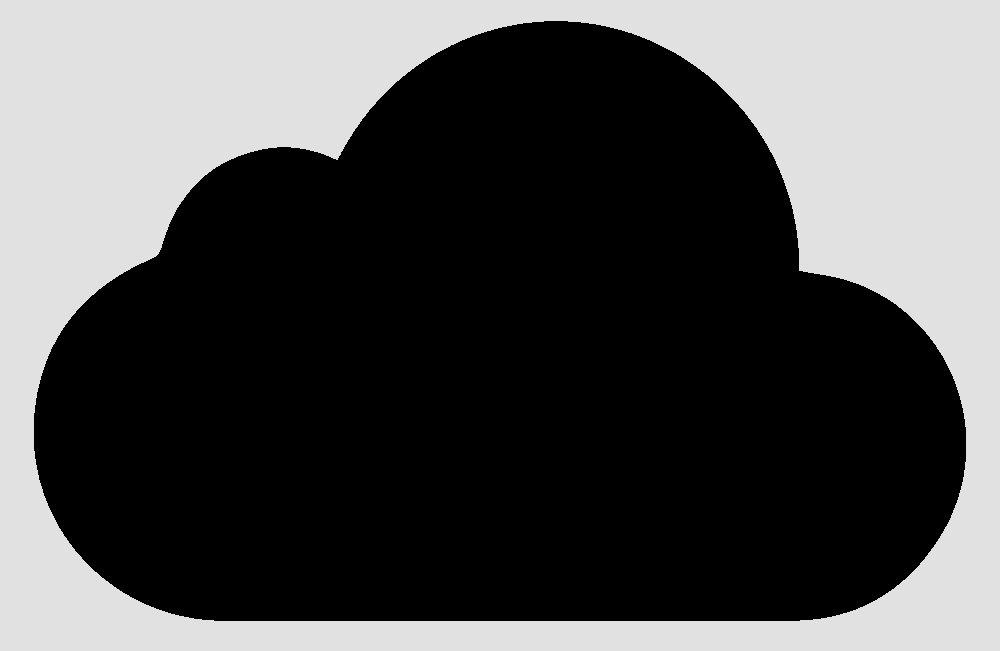

In [168]:
#TAMPILKAN MASKING
from google.colab.patches import cv2_imshow

cv2_imshow(cloud_mask)

In [194]:
#wordcloud label negative

negative = data[data.Sentiment == 0]
normal_string = []

for t in negative.clean_teks:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep='')

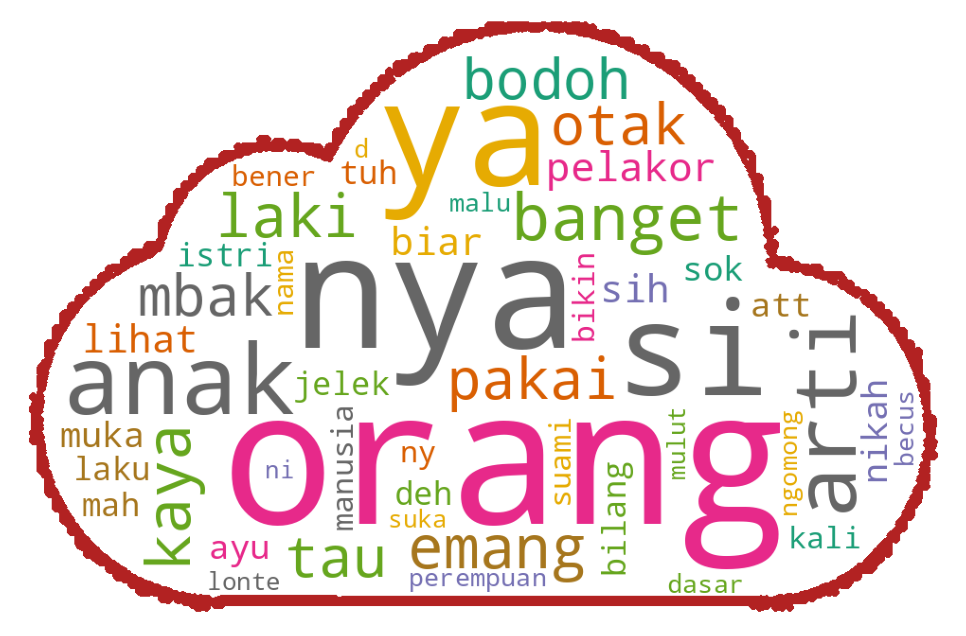

In [200]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load mask image
cloud_mask = np.array(Image.open("cloud.jpg"))

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=250).generate(normal_string)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [201]:
#wordcloud label positive

positive = data[data.Sentiment == 1]
fraud_string = []

for t in positive.clean_teks:
  fraud_string.append(t)

fraud_string = pd.Series(fraud_string).str.cat(sep='')

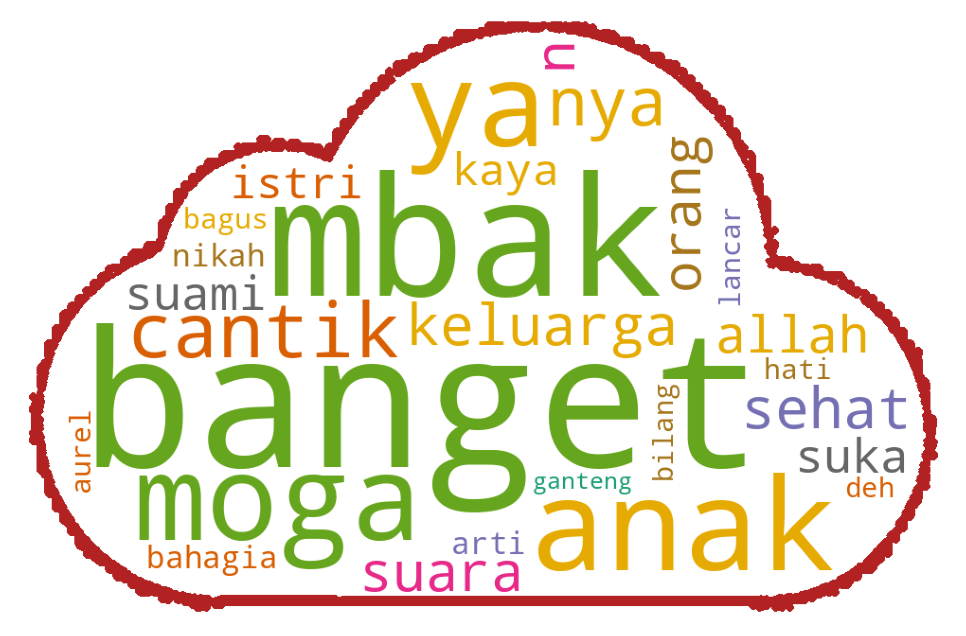

In [205]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load mask image
cloud_mask = np.array(Image.open("cloud.jpg"))

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=200).generate(fraud_string)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()